In [1]:
import numpy as np 
import pandas as pd
import os
from gtda.time_series import PearsonDissimilarity,SlidingWindow
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape
from gtda.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split, RepeatedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix,precision_score,cohen_kappa_score, f1_score, accuracy_score
from sklearn.utils import shuffle
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
warnings.filterwarnings("ignore")

import glob
import pickle

In [2]:
pwd

'/home/data1/maliang/EEG_related/WAUC'

In [3]:
def pickle_obj(path, prefix_name, x_map_, y_map_):
    for i in range(3):
        x_pwi = np.concatenate(x_map_[str(i)], axis=0)
        y_pwi = np.array(y_map_[str(i)])
        if prefix_name == "":
            # mixed_subject 情况下保存的路径与文件名
            x_name = "x_pw{}.pkl".format(i)
            y_name = "y_pw{}.pkl".format(i)
        else:
            # intra_subject 情况下保存的路径与文件名
            x_name = "{}_x_pw{}.pkl".format(prefix_name,i)
            y_name = "{}_y_pw{}.pkl".format(prefix_name,i)
        with open(os.path.join("./pkl_dir/{}".format(path), x_name), "wb") as f:
            pickle.dump(x_pwi, f)
        with open(os.path.join("./pkl_dir/{}".format(path), y_name), "wb") as f:
            pickle.dump(y_pwi, f)

In [4]:
def _gtda(data, sliding_win=2, overlap_win=2, fs=500):
    """
    data: raw dataset
    sliding win: to represent sliding window in second 
    overlap win: to represent overlap window in second
    """
    sliding_samples = int(sliding_win * fs)
    overlap_samples = int(overlap_win * fs)
    step = [
        SlidingWindow(size=sliding_samples,stride=overlap_samples),
        PearsonDissimilarity(absolute_value=True),
        VietorisRipsPersistence(metric='precomputed'),
        PersistenceLandscape()
    ]
    tda = make_pipeline(*step).fit_transform(data)
    return np.reshape(tda,newshape=(-1,tda.shape[1]*tda.shape[2]))

In [5]:
# generate mixed samples and labels
def generate_sample_label(sliding_win=1, overlap_win=0.5):
#     path = './processed_data'
    path = "./filtered_data/"
    file_list = os.listdir(path)
    x_map = {"0":[],"1":[],"2":[],}
    y_map = {"0":[],"1":[],"2":[],}
    failure_nums = 0
    for file_name in file_list:
        if not str(file_name).endswith("txt"):
            continue
        file_path = os.path.join(path,file_name)
        raw_labels = file_name.split('.')[0].split('_')[-1]
        pw_label = raw_labels[1]
        data = np.loadtxt(file_path,delimiter=",")
        print(data.shape)
        #break
#         print(True in np.isnan(data))
        try:
            # 修改滑动窗口的大小
            feat = _gtda(data,sliding_win=sliding_win, overlap_win=overlap_win)
        except Exception as e:
            print("except file {}".format(file_name))
            failure_nums += 1
            continue
        print("load file {}".format(file_name), end=", ")
        #print(feat.shape)
        mw_label = int(raw_labels[0])
        y_map[pw_label] += [mw_label]*len(feat)
        x_map[pw_label].append(feat)
#         break
    print("\n failure loading nums {} #".format(failure_nums))
    return x_map, y_map

In [6]:
def gen_LOSO_sample_label(sliding_win=1, overlap_win=0.5):
    # 原始数据长度 300，000
    # 
    each_nums = int((300000/500)/(sliding_win-overlap_win) - 1)
    each_nums *= 2  
    for pw_level in range(3):
        sample_file_name = "x_pw{}.pkl".format(pw_level)
        label_file_name = "y_pw{}.pkl".format(pw_level)
        with open(os.path.join("./pkl_dir/mixed_subject", sample_file_name), "rb") as pkl_file:
            sample_pwi = pickle.load(pkl_file)
        with open(os.path.join("./pkl_dir/mixed_subject", label_file_name), "rb") as pkl_file:
            label_pwi = pickle.load(pkl_file)
        #print(sample_pwi.shape)
        #print(label_pwi.shape)
        #break
        index = np.argwhere(sample_pwi[:,0] != np.NaN)
        index = index.flatten()
#         print(index)
        for i in range(47):
            # len(data)/(SW-Overlap) - 1
            s = i * each_nums 
            e = s + each_nums
            test_index = index[s:e]
            front, end = index[:s],index[e:]
            train_index = np.concatenate([front, end], axis=0)
            test_samples = sample_pwi[test_index,:]
            train_samples = sample_pwi[train_index,:]
            
            test_labels = label_pwi[test_index]
            train_labels = label_pwi[train_index]
            print(train_samples.shape, train_labels.shape,end=", ")
            print(test_samples.shape, test_labels.shape, end=", ")
#             print(train_index, test_index)
#             print(train_index, test_index)
            with open(os.path.join("./pkl_dir/{}".format("LOSO"), "leave{}_train_sample_pw{}.pkl".format(i+1,pw_level)), "wb") as f:
                pickle.dump(train_samples, f)
            with open(os.path.join("./pkl_dir/{}".format("LOSO"), "leave{}_train_label_pw{}.pkl".format(i+1,pw_level)),"wb") as f:
                pickle.dump(train_labels, f)
            
            with open(os.path.join("./pkl_dir/{}".format("LOSO"), "leave{}_test_sample_pw{}.pkl".format(i+1,pw_level)), "wb") as f:
                pickle.dump(test_samples, f)
            with open(os.path.join("./pkl_dir/{}".format("LOSO"), "leave{}_test_label_pw{}.pkl".format(i+1,pw_level)),"wb") as f:
                pickle.dump(test_labels, f)
            print("leave subject {} out".format(i), end=", ")

In [61]:
#TODO
gen_LOSO_sample_label(sliding_win=4, overlap_win=2)

(27508, 200) (27508,), (598, 200) (598,), leave subject 0 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 1 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 2 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 3 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 4 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 5 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 6 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 7 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 8 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 9 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 10 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 11 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 12 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 13 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 14 out, (27508, 200) (27508,), (598, 200) (598,), leave su

KeyboardInterrupt: 

In [35]:
os.listdir("./filtered_data/")

['S20_session4_024.txt',
 'S39_session3_012.txt',
 'S40_session6_125.txt',
 'S15_session2_101.txt',
 'S14_session4_101.txt',
 'S22_session6_101.txt',
 'S44_session6_113.txt',
 'S41_session6_000.txt',
 'S3_session4_113.txt',
 'S31_session3_125.txt',
 'S6_session2_113.txt',
 'S26_session4_125.txt',
 'S15_session4_125.txt',
 'S46_session1_000.txt',
 'S2_session1_113.txt',
 'S21_session2_012.txt',
 'S43_session3_101.txt',
 'S3_session5_000.txt',
 'S35_session5_113.txt',
 'S16_session3_125.txt',
 'S43_session1_012.txt',
 'S3_session2_024.txt',
 'S27_session5_000.txt',
 'S45_session1_012.txt',
 'S35_session4_101.txt',
 'S19_session6_101.txt',
 'S14_session5_024.txt',
 'S26_session2_113.txt',
 'S23_session2_000.txt',
 'S30_session2_012.txt',
 'S27_session4_125.txt',
 'S47_session2_012.txt',
 'S5_session3_113.txt',
 'S10_session2_101.txt',
 'S21_session1_113.txt',
 'S43_session6_125.txt',
 'S46_session5_113.txt',
 'S14_session3_000.txt',
 'S23_session6_125.txt',
 'S47_session6_125.txt',
 'S32_

In [7]:
def gen_intra_sub_sample_label(sliding_win=1, overlap_win=0.5):
    path = "./filtered_data/"
    map_x = {"0":[],"1":[],"2":[],}
    map_y = {"0":[],"1":[],"2":[],}
    #file_list = os.listdir(path)
    file_list = ["S42_session4_024.txt"]
    failure_nums = 0
#    sub_id = "S1"
    sess_nums=0
    for file_name in file_list:
        if not str(file_name).endswith("txt"):
            continue
        file_path = os.path.join(path,file_name)
        temp = file_name.split('.')[0].split('_')
        raw_labels = temp[-1]
        pw_label = raw_labels[1]
        sub_id = temp[0]
        data = np.loadtxt(file_path,delimiter=",")
        try:
            feat = _gtda(data,sliding_win=sliding_win, overlap_win=overlap_win)
        except Exception as e:
            print(e)
            print("except file {}".format(file_name))
            failure_nums += 1
            continue
        print("load file {}".format(file_name), end=", ")
        sess_nums += 1
        mw_label = int(raw_labels[0])
        map_y[pw_label] += [mw_label]*len(feat)
        map_x[pw_label].append(feat)
        if sess_nums == 6:
            sess_nums =0
            print(map_x)
            pickle_obj("intra_subject", sub_id, map_x, map_y)
            map_x = {"0":[],"1":[],"2":[],}
            map_y = {"0":[],"1":[],"2":[],}

In [8]:
def Kfold_validation(classifier,sample_pwi,label_pwi,groups, sw=1, sub="666", path="mixed_sub_rs", pw_level=0, show_cm=1, repeats=10):
    results = np.zeros((repeats*5, 7))
    gkf = GroupKFold(n_splits=5)
    #kf = RepeatedKFold(n_splits=5, n_repeats=repeats, random_state=666)
    for idx, train_test_index in enumerate(gkf.split(sample_pwi, label_pwi, groups)):
        x_train, y_train, x_test, y_test = sample_pwi[train_test_index[0]], label_pwi[train_test_index[0]], sample_pwi[train_test_index[1]], label_pwi[train_test_index[1]]
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        y_prob = classifier.predict_proba(x_test)[:,1]
        if show_cm:
            cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
            draw_confusion_matrix(cf_matrix, ["low", "high"], "sub{} pw{} of {} task".format(sub, pw_level, path.split("_")[0]))
            show_cm = 0
        cohen_kappa_s = cohen_kappa_score(y_test, y_pred)
        roc_score = roc_auc_score(y_test, y_prob)
        acc = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
        micro_precision_s = precision_score(y_test, y_pred, average="micro")
        macro_precision_s = precision_score(y_test, y_pred, average="macro")
        weight_precision_s = precision_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="micro")
        results[idx, :] = roc_score, cohen_kappa_s, micro_precision_s, macro_precision_s, weight_precision_s, f1, acc
    np.savetxt("./all_result/{}/{}/{}_rs{}.csv".format(path,sw, sub, pw_level), results, delimiter=",", fmt="%10.5f")  

In [9]:
def draw_confusion_matrix(cm, label_names, name):
    sns.set()
    mpl.rcParams['font.sans-serif'] = 'Times New Roman'
    mpl.rcParams['axes.unicode_minus'] = False
    f, ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax=ax)
    ax.set(xticklabels=label_names, yticklabels=label_names)
    ax.set_title('{}'.format(name), fontsize=16, fontweight='bold')
    ax.set_xlabel('Pred Class', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Class', fontsize=14, fontweight='bold')
#     plt.savefig(os.path.join(os.path.join(path, name), name))

In [10]:
def mixed_subject(classifier):
    
    for i in range(3):
        repeats = 1
        with open(os.path.join("./pkl_dir/mixed_subject", "x_pw{}.pkl".format(i)), "rb") as pkl_file:
            sample_pwi = pickle.load(pkl_file)
        with open(os.path.join("./pkl_dir/mixed_subject", "y_pw{}.pkl".format(i)), "rb") as pkl_file:
            label_pwi = pickle.load(pkl_file)
        #results = np.zeros((repeats*5, 5))
        # sample_pwi.shape, label_pwi.shape
        # x_train, x_test, y_train, y_test = train_test_split(sample_pwi, label_pwi, test_size=0.2, random_state=666,shuffle=True)
        Kfold_validation(classifier,sample_pwi,label_pwi,sub="666",path="mixed_sub_rs", pw_level=i, repeats=repeats)         


FileNotFoundError: [Errno 2] No such file or directory: './all_result/mixed_sub_rs/S666_mixed_rs0.csv'

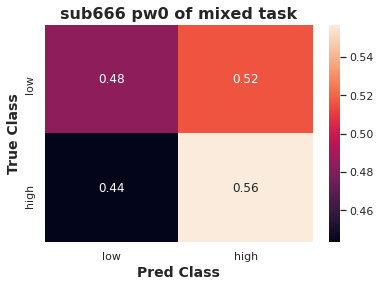

In [20]:
# 每种实验的分类器都需要重新实例化
#clf = RandomForestClassifier()
clf = LR()
mixed_subject(clf)

In [11]:
def gen_intra_sub_sample_label(sliding_win=1, overlap_win=0.5):
    path = "./filtered_data/"
    failure_nums = 0
    subjects = [i for i in range(1, 48+1)]
    for s_id in subjects:
        if s_id == 28:
            continue
        map_x = {"0":[],"1":[],"2":[]}
        map_y = {"0":[],"1":[],"2":[]}
        for sess_i in range(1, 6+1):
            file_search = "S{}_session{}_*.txt".format(s_id, sess_i)
            file_path = os.path.join(path, file_search)
            rs = glob.glob(file_path)
            #print(rs)
            if len(rs):
                file_name = rs[0]
            else:
                raise ValueError("")
            session_suffix = file_name.split("/")[-1].split(".")[0].split("_")[-1]
            pw_label = session_suffix[1]
            sub_id = f"S{s_id}"
            data = np.loadtxt(file_name,delimiter=",")
            try:
                feat = _gtda(data,sliding_win=sliding_win, overlap_win=overlap_win)
            except Exception as e:
                print(e)
                print("except file {}".format(file_name))
                failure_nums += 1
                continue
            print("load file {}".format(file_name), end=", ")
            mw_label = int(session_suffix[0])
            map_y[pw_label] += [mw_label]*len(feat)
            map_x[pw_label].append(feat)
          
        yield map_x, map_y, sub_id

In [13]:
from time import time

In [16]:
def intra_subject(sw):
    for sub_x, sub_y, sub_id in gen_intra_sub_sample_label(sliding_win=sw, overlap_win=sw/2):
        for pw_level in range(3):
            clf = RF()
            #clf = LR(n_jobs=-1)
            #clf = KNN(n_jobs=-1)
            #clf = MLP()
            # 为当前样本进行5折交叉
            sample_pwi = np.array(sub_x[str(pw_level)])
            label_pwi = np.array(sub_y[str(pw_level)])
            
            #print(sample_pwi.shape)
            #print(np.unique(label_pwi))
            #print(label_pwi.shape)
            n_samples = sample_pwi.shape[1]
            groups = np.zeros(n_samples)
            groups[:int(n_samples/5)] = 1
            groups[int(n_samples/5):int(n_samples*2/5)] = 2
            groups[int(n_samples*2/5):int(n_samples*3/5)] = 3
            groups[int(n_samples*3/5):int(n_samples*4/5)] = 4
            groups[int(n_samples*4/5):] = 5
            groups = np.tile(groups, 2)
            sample_pwi = np.concatenate(sample_pwi)
            start = time()
            Kfold_validation(clf, sample_pwi, label_pwi,groups,sw=sw, sub=sub_id, path="RF/intra_sub_rs", pw_level=pw_level, show_cm=0, repeats=1)
            end = time()
            print(f"pw{pw_level+1}: {end-start}s")


In [ ]:
# 每种实验的分类器都需要重新实例化
for s in range(4, 5):
    print("\n")
    print(f"cur win is: {s}s, stride is: {s/2}s")
    print("\n")
    intra_subject(s)

In [73]:
# def intra_subject(sw):
#     subjects = [i for i in range(1, 48+1)]
#     for sub_id in subjects:
#         if sub_id == 28:
#             continue
#         for pw_level in range(3):
#             #clf = RF()
#             #clf = LR(n_jobs=-1)
#             #clf = KNN(n_jobs=-1)
#             clf = MLP()
#             sample_file_name = "S{}_x_pw{}.pkl".format(sub_id, pw_level)
#             label_file_name = "S{}_y_pw{}.pkl".format(sub_id, pw_level)
#             with open(os.path.join("./pkl_dir/intra_subject", sample_file_name), "rb") as pkl_file:
#                 sample_pwi = pickle.load(pkl_file)
#             with open(os.path.join("./pkl_dir/intra_subject", label_file_name), "rb") as pkl_file:
#                 label_pwi = pickle.load(pkl_file)
#             # 为当前样本进行5折交叉
 
#             n0_samples = np.where(label_pwi==0).shape[0]
#             groups = np.zeros(n_samples)
#             groups[:int(n_samples/5)] = 1
#             groups[int(n_samples/5):int(n_samples*2/5)] = 2
#             groups[int(n_samples*2/5):int(n_samples*3/5)] = 3
#             groups[int(n_samples*3/5):int(n_samples*4/5)] = 4
#             groups[int(n_samples*4/5):] = 5
            
#             Kfold_validation(clf, sample_pwi, label_pwi,groups,sw=sw, sub=sub_id, path="MLP/intra_sub_rs", pw_level=pw_level, show_cm=1, repeats=1)


In [74]:
# 每种实验的分类器都需要重新实例化
for s in range(1, 5):
    print("\n")
    print(f"cur win is: {s}s, stride is: {s/2}s")
    print("\n")
    intra_subject(s)



cur win is: 1s, stride is: 0.5s





IndexError: string index out of range

In [80]:
def LOSO(sw=1):
    roc_scores = []
    for pw_level in range(0,3):
        results = np.zeros((48, 6))
        for i in range(1,48):
            #classifier = RandomForestClassifier()
            #clf = LR()
            #clf = KNN()
            clf = MLP()
            train_sample_file = "leave{}_train_sample_pw{}.pkl".format(i, pw_level)
            train_label_file = "leave{}_train_label_pw{}.pkl".format(i, pw_level)
            test_sample_file = "leave{}_test_sample_pw{}.pkl".format(i, pw_level)
            test_label_file = "leave{}_test_label_pw{}.pkl".format(i, pw_level)
            with open(os.path.join("./pkl_dir/LOSO", train_sample_file), "rb") as pkl_file:
                leavei_train_x_pwj = pickle.load(pkl_file)
            with open(os.path.join("./pkl_dir/LOSO", train_label_file), "rb") as pkl_file:
                leavei_train_y_pwj = pickle.load(pkl_file) 
            with open(os.path.join("./pkl_dir/LOSO", test_sample_file), "rb") as pkl_file:
                leavei_test_x_pwj = pickle.load(pkl_file)
            with open(os.path.join("./pkl_dir/LOSO", test_label_file), "rb") as pkl_file:
                leavei_test_y_pwj = pickle.load(pkl_file)

            x_train, y_train, x_test, y_test = leavei_train_x_pwj,leavei_train_y_pwj,leavei_test_x_pwj,leavei_test_y_pwj
            
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            y_prob = clf.predict_proba(x_test)[:,1]
            
            cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
            draw_confusion_matrix(cf_matrix, ["low", "high"], "LOSO_{}_pw{}".format(i, pw_level))
            
            cohen_kappa_s = cohen_kappa_score(y_test, y_pred)
            roc_score = roc_auc_score(y_test, y_prob)
            micro_precision_s = precision_score(y_test, y_pred, average="micro")
            macro_precision_s = precision_score(y_test, y_pred, average="macro")
            weight_precision_s = precision_score(y_test, y_pred, average="weighted")
            f1 = f1_score(y_test, y_pred, average="micro")
            results[i, :] = roc_score, cohen_kappa_s, micro_precision_s, macro_precision_s, weight_precision_s,f1
        np.savetxt("./all_result/{}/{}/{}_pw{}.csv".format("LOSO_rs",sw, "LOSO", pw_level), results, delimiter=",", fmt="%10.5f") 


In [37]:
for s in range(1, 5):
    print("\n")
    print(f"cur win is: {s}s, stride is: {s/2}s")
    print("\n")
    gen_LOSO_sample_label(sliding_win=4, overlap_win=2)
    LOSO(s)



cur win is: 1s, stride is: 0.5s


(27508, 200) (27508,), (598, 200) (598,), leave subject 0 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 1 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 2 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 3 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 4 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 5 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 6 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 7 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 8 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 9 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 10 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 11 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 12 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 13 out, (27508, 200) (27508,), (598, 200) (598,), leave subject 14 out, (27508, 200) (

KeyboardInterrupt: 